In [70]:
import numpy as np
import matplotlib.pyplot as plt

from typing import Union

In [3]:
ACTIONS = (0., 0.25, 0.5, 0.75, 1.)

# Define Reward Functions

In [198]:
# For simplicity we inject directly the PA.
# PA = 1 - current_price / average_price
# It can be a variable within the range of [-inf, 1].
# Realistically speaking probably will be mostly within [-0.5, 0.5].
# Only if the price drops completely or spikes like with 100-200% within a month this will not be true.
# Usually that is not the case.

def price_advantage_reward_func(pa: float, action: float, reward_scaling: float = 1.) -> float:
    reward = reward_scaling * action * pa
        
    return reward


def price_advantage_sin_reward_func(pa: float, action: float, reward_scaling: float = 1.) -> float:
    pa = pa * np.pi / 2
    pa = np.clip(pa, a_min=-np.pi/2, a_max=np.pi/2)
    reward = reward_scaling * action * np.sin(pa)
        
    return reward

def no_action_reward_func(pa: float, action: float, reward_scaling: float = 1.) -> float:
    if action == 0.:
        pa = pa * np.pi / 2
        pa = np.clip(pa, a_min=-np.pi/2, a_max=np.pi/2) 
        
        return np.sin(pa + np.pi) * reward_scaling
    else:
        return 0.
    

def action_magnitude_reward_func(action: float, reward_scaling: float = 1.) -> float:
    reward = action ** 2
    reward = -reward * reward_scaling

    return reward

vec_price_advantage_sin_reward_func = np.vectorize(price_advantage_sin_reward_func)
vec_price_advantage_reward_func = np.vectorize(price_advantage_reward_func)
vec_no_action_reward_func = np.vectorize(no_action_reward_func)

# Plot Reward Functions Withot Any Scaling

In [210]:
def plot_pa_reward_func(func, actions, reward_scaling):
    pa_range = np.arange(-1.5, 1., step=0.01)
    for action in actions:
        rewards = func(pa_range, action, reward_scaling)
        plt.plot(pa_range, rewards, label=f'{action}')
    plt.legend()


def plot_action_magnitude_rewards_for(actions, reward_scaling: float):
    labels = []
    rewards = []
    for action in actions:
        labels.append(str(action))
        rewards.append(
            action_magnitude_reward_func(action, reward_scaling)
        )

    plt.bar(labels, rewards)
    

def plot_all(actions, reward_scaling: Union[float, int, list]):
    if isinstance(reward_scaling, (int, float)):
        reward_scaling = [reward_scaling] * 3
        
    pa_range = np.arange(-1.5, 1., step=0.01)
    for action in actions:
        pa_rewards = vec_price_advantage_reward_func(pa_range, action, reward_scaling[0])
        no_action_rewards = vec_no_action_reward_func(pa_range, action, reward_scaling[1])
        action_magnitude_reward = action_magnitude_reward_func(action, reward_scaling[2])
        rewards = pa_rewards + no_action_rewards + action_magnitude_reward
        plt.plot(pa_range, rewards, label=f'{action}')
        
    plt.hlines(y=1, xmin=pa_range.min(), xmax=pa_range.max(), color='k', linestyle='--', linewidth=0.5)
    plt.hlines(y=-1, xmin=pa_range.min(), xmax=pa_range.max(), color='k', linestyle='--', linewidth=0.5)
    
    plt.vlines(x=0., ymin=-5, ymax=5, color='k', linestyle='--', linewidth=0.5)
    plt.vlines(x=0.5, ymin=-5, ymax=5, color='k', linestyle='--', linewidth=0.5)
    plt.vlines(x=-0.5, ymin=-5, ymax=5, color='k', linestyle='--', linewidth=0.5)
    plt.vlines(x=1., ymin=-5, ymax=5, color='k', linestyle='--', linewidth=0.5)
    plt.vlines(x=-1., ymin=-5, ymax=5, color='k', linestyle='--', linewidth=0.5)
    
    
    plt.legend()
    

def plot_all_sin(actions, reward_scaling: Union[float, int, list]):
    if isinstance(reward_scaling, (int, float)):
        reward_scaling = [reward_scaling] * 3
        
    pa_range = np.arange(-1.5, 1., step=0.01)
    for action in actions:
        pa_rewards = vec_price_advantage_sin_reward_func(pa_range, action, reward_scaling[0])
        no_action_rewards = vec_no_action_reward_func(pa_range, action, reward_scaling[1])
        action_magnitude_reward = action_magnitude_reward_func(action, reward_scaling[2])
        rewards = pa_rewards + no_action_rewards + action_magnitude_reward
        plt.plot(pa_range, rewards, label=f'{action}')
        
    plt.hlines(y=1, xmin=pa_range.min(), xmax=pa_range.max(), color='k', linestyle='--', linewidth=0.5)
    plt.hlines(y=-1, xmin=pa_range.min(), xmax=pa_range.max(), color='k', linestyle='--', linewidth=0.5)
    
    plt.vlines(x=0., ymin=-5, ymax=5, color='k', linestyle='--', linewidth=0.5)
    plt.vlines(x=0.5, ymin=-5, ymax=5, color='k', linestyle='--', linewidth=0.5)
    plt.vlines(x=-0.5, ymin=-5, ymax=5, color='k', linestyle='--', linewidth=0.5)
    plt.vlines(x=1., ymin=-5, ymax=5, color='k', linestyle='--', linewidth=0.5)
    plt.vlines(x=-1., ymin=-5, ymax=5, color='k', linestyle='--', linewidth=0.5)
    
    plt.legend()

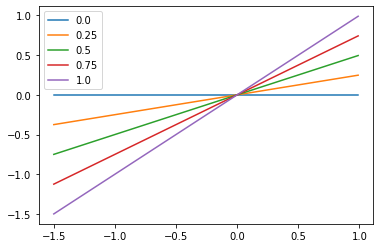

In [203]:
plot_pa_reward_func(func=vec_price_advantage_reward_func, actions=ACTIONS, reward_scaling=1)

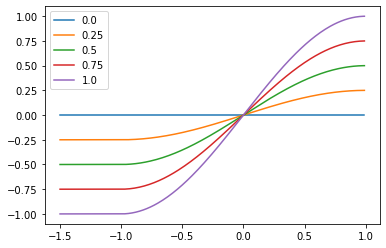

In [204]:
plot_pa_reward_func(func=vec_price_advantage_sin_reward_func, actions=ACTIONS, reward_scaling=1)

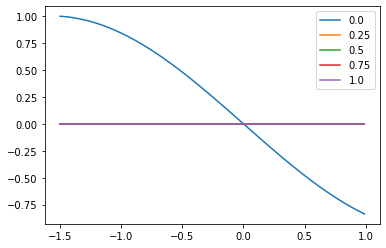

In [205]:
plot_pa_reward_func(func=vec_no_action_lin_reward_func, actions=ACTIONS, reward_scaling=1)

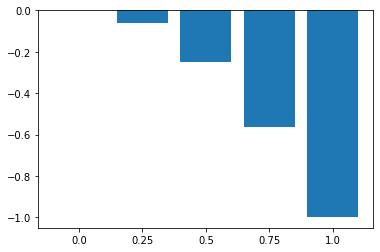

In [97]:
plot_action_magnitude_rewards_for(actions=ACTIONS, reward_scaling=1)

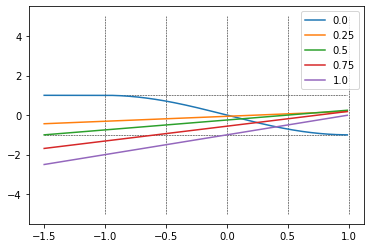

In [211]:
plot_all(actions=ACTIONS, reward_scaling=(1., 1., 1.))

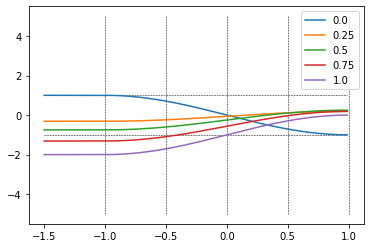

In [212]:
plot_all_sin(actions=ACTIONS, reward_scaling=(1., 1., 1.))

It is obvious that without reward scaling this function will not work. Positive rewards will come out only from pa > 0.25, which are already only rare events. So lets tune this baby up.
Also, the sin functions look more smooth on extreme events, let's try to use it.

# Reward Scaling

We are looking for two things. This is my intuition, but more experiments should be done in all the cases:
1. Give to the agent positive rewards more easily, but not too easily. We don't want a symmetric function in 0, because than the action magnitude function is useless.
2. The no action reward function should be lower than the price advantage reward function. Otherwise, the agent will most probably just keep the cash and that is it.


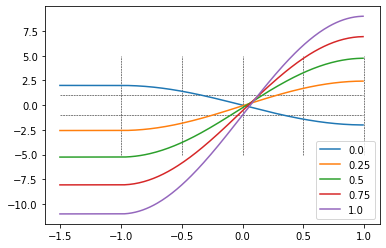

In [213]:
# Positive rewards come only from pa ~= 0.1. Lets shift it a bit more.
plot_all_sin(actions=ACTIONS, reward_scaling=(10., 2., 1.))

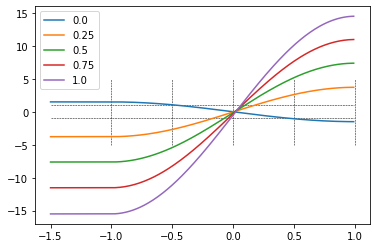

In [214]:
# This looks like what I am looking for.
plot_all_sin(actions=ACTIONS, reward_scaling=(15.0, 1.5, 0.5))

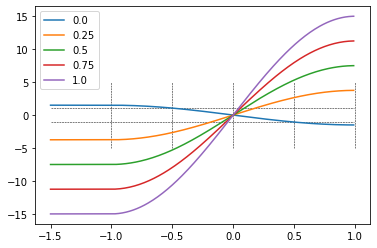

In [215]:
# No action magnitude reward. We can see that it is centered in 0.
plot_all_sin(actions=ACTIONS, reward_scaling=(15.0, 1.5, 0.))

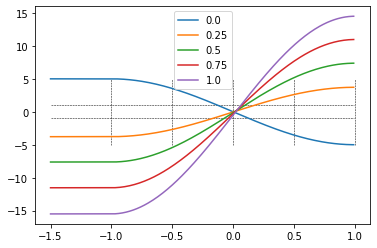

In [216]:
# Price advantage symmetric with no action reward.
plot_all_sin(actions=ACTIONS, reward_scaling=(15.0, 5., 0.5))